# Diffusion Maps + KSWGD Generative Modelling on CIFAR-10

This notebook implements an autoencoder + diffusion-maps latent analysis, then mirrors the KSWGD scheme from Tests 1 & 2 to sample new CIFAR-10 images directly in latent space.

**Dataset: CIFAR-10**
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- 32×32 RGB color images (3 channels)
- 50,000 training / 10,000 test images

**Pipeline:**

1. Load CIFAR-10 and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates for diagnostics.
5. Build the KSWGD kernel operators on the latent samples (same normalization as Tests 1 & 2).
6. Run KSWGD particle transport to draw new latent vectors.
7. Decode KSWGD latent vectors back to images and visually inspect generated images.

In [1]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from tqdm.auto import trange
import diffusers
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    TORCHMETRICS_AVAILABLE = True
except ImportError:
    FrechetInceptionDistance = None
    TORCHMETRICS_AVAILABLE = False

from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_AVAILABLE = False

np.random.seed(1)
torch.manual_seed(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu_kswgd = bool(GPU_AVAILABLE and torch.cuda.is_available())

print(f"Diffusers version: {diffusers.__version__}")

print("=" * 50)
print("GPU Info")
print("=" * 50)
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}, Memory: {props.total_memory / 1024**3:.2f} GB")
else:
    print("No CUDA GPU available")

print(f"\nUsing device: {device}")
print(f"KSWGD GPU backend: {'enabled' if use_gpu_kswgd else 'disabled'}")

Diffusers version: 0.36.0
GPU Info
CUDA version: 12.8
cuDNN version: 91002
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 5050 Laptop GPU, Memory: 7.96 GB

Using device: cuda
KSWGD GPU backend: enabled


In [2]:
# Load CIFAR-10 datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1], shape: 3x32x32
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Classes:", train_dataset.classes)
print("Image shape: 3x32x32 (RGB color)")

Train size: 50000 Test size: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape: 3x32x32 (RGB color)


In [3]:
# Load a pretrained Stable Diffusion VAE and wrap it for CIFAR-10 usage
vae_repo_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(
    vae_repo_id,
    torch_dtype=torch.float32,
)
vae = vae.to(device)
vae_scaling = float(getattr(vae.config, "scaling_factor", 0.18215))

# Freeze the encoder except for the last down block (optional fine-tuning target)
for param in vae.encoder.parameters():
    param.requires_grad = False
for param in vae.encoder.down_blocks[-1].parameters():
    param.requires_grad = True

print("Loaded VAE:", vae_repo_id)
print("Latent channels:", vae.config.latent_channels)
print("Scaling factor:", vae_scaling)


def _to_vae_range(x: torch.Tensor) -> torch.Tensor:
    """Map [0, 1] RGB tensors to [-1, 1] for the SD VAE."""
    return (x * 2.0) - 1.0


def _from_vae_range(x: torch.Tensor) -> torch.Tensor:
    """Map [-1, 1] outputs back to [0, 1]."""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)


class DiffusersAutoencoderWrapper(nn.Module):
    """Thin wrapper so downstream cells can keep using the `autoencoder` API."""

    def __init__(self, vae: AutoencoderKL, device: torch.device, image_size: int = 32):
        super().__init__()
        self.vae = vae
        self.device = device
        self.scaling_factor = float(getattr(vae.config, "scaling_factor", 0.18215))
        with torch.no_grad():
            dummy = torch.zeros(1, 3, image_size, image_size, device=device)
            latent = self.vae.encode(_to_vae_range(dummy)).latent_dist.mode()
        self.latent_shape = latent.shape[1:]
        self.latent_dim = int(np.prod(self.latent_shape))

    def encode_latents(self, images: torch.Tensor) -> torch.Tensor:
        posterior = self.vae.encode(_to_vae_range(images))
        latents = posterior.latent_dist.mode() * self.scaling_factor
        return latents

    def decode_latents(self, latents: torch.Tensor) -> torch.Tensor:
        decoded = self.vae.decode(latents / self.scaling_factor).sample
        return _from_vae_range(decoded)

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        latents = self.encode_latents(images)
        return latents.view(latents.size(0), -1)

    def decode(self, flat_latents: torch.Tensor) -> torch.Tensor:
        latents = flat_latents.view(-1, *self.latent_shape)
        return self.decode_latents(latents)

    def forward(self, images: torch.Tensor):
        latents_flat = self.encode(images)
        recon = self.decode(latents_flat)
        return recon, latents_flat


autoencoder = DiffusersAutoencoderWrapper(vae, device=device, image_size=32).to(device)
autoencoder.eval()
print(f"Autoencoder wrapper latent dim: {autoencoder.latent_dim}")

Loaded VAE: stabilityai/sd-vae-ft-mse
Latent channels: 4
Scaling factor: 0.18215
Autoencoder wrapper latent dim: 64


In [4]:
# Optional fine-tuning utilities for adapting the pretrained VAE to CIFAR-10

def finetune_vae(
    model,
    dataloader,
    epochs=5,
    lr=1e-5,
    max_batches=None,
):
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if not trainable_params:
        print("No trainable parameters detected; skipping fine-tuning.")
        return

    optimizer = torch.optim.Adam(trainable_params, lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        steps = 0
        for step, (imgs, _) in enumerate(dataloader):
            if max_batches is not None and step >= max_batches:
                break
            imgs = imgs.to(device)
            latents = model.encode(_to_vae_range(imgs)).latent_dist.sample()
            recon = model.decode(latents).sample
            recon_rgb = _from_vae_range(recon)
            loss = loss_fn(recon_rgb, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            steps += 1
        avg_loss = running_loss / max(1, steps)
        print(f"[VAE FT] epoch {epoch + 1}/{epochs} | loss={avg_loss:.5f}")
    model.eval()
    print("Finished VAE fine-tuning.")

In [5]:
# Execute (optional) VAE fine-tuning before reconstruction diagnostics
do_finetune = False
finetune_epochs = 5
finetune_lr = 1e-5
finetune_max_batches = None  # e.g., set to 200 for a quick pass

if do_finetune:
    print(f"Fine-tuning VAE for {finetune_epochs} epochs at lr={finetune_lr}")
    finetune_vae(
        vae,
        train_loader,
        epochs=finetune_epochs,
        lr=finetune_lr,
        max_batches=finetune_max_batches,
    )
else:
    print("Skipping VAE fine-tuning (set do_finetune=True to enable).")

vae.eval()
autoencoder.eval()

Skipping VAE fine-tuning (set do_finetune=True to enable).


DiffusersAutoencoderWrapper(
  (vae): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlo

In [6]:
# Reconstruction diagnostics utilities for the pretrained VAE

def evaluate_vae_reconstruction(
    model: AutoencoderKL,
    dataloader: DataLoader,
    device: torch.device,
    num_batches: int = 1,
):
    model.eval()
    mse_loss = nn.MSELoss(reduction="mean")
    mse_values = []
    originals = []
    reconstructions = []

    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            imgs = imgs.to(device)
            latents = model.encode(_to_vae_range(imgs)).latent_dist.mode() * vae_scaling
            recon = model.decode(latents / vae_scaling).sample
            recon_rgb = _from_vae_range(recon)
            loss = mse_loss(recon_rgb, imgs)

            mse_values.append(loss.item())
            originals.append(imgs.cpu())
            reconstructions.append(recon_rgb.cpu())

    if not mse_values:
        raise RuntimeError("No batches were evaluated; increase num_batches.")

    mean_mse = float(np.mean(mse_values))
    psnr = -10.0 * np.log10(mean_mse + 1e-8)

    originals = torch.cat(originals, dim=0)
    reconstructions = torch.cat(reconstructions, dim=0)

    return {
        "mse": mean_mse,
        "psnr": psnr,
        "originals": originals,
        "reconstructions": reconstructions,
    }

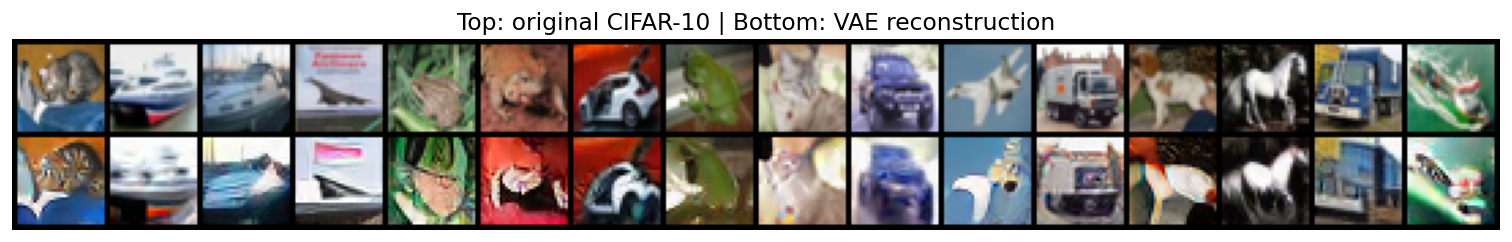

Reconstruction MSE=0.021395 | PSNR=16.70 dB
Status: TUNE (threshold=0.003)
Frechet Inception Distance unavailable (install torchmetrics>=1.0)


In [7]:
# Evaluate reconstructions (Cell 8) and visualize originals vs. reconstructions
num_eval_batches = 2
recon_report = evaluate_vae_reconstruction(
    vae,
    test_loader,
    device=device,
    num_batches=num_eval_batches,
)

orig_samples = recon_report["originals"][:16]
recon_samples = recon_report["reconstructions"][:16]
comparison = torch.cat([orig_samples, recon_samples], dim=0)

grid = make_grid(comparison, nrow=16)
plt.figure(figsize=(16, 2.5))
plt.imshow(np.clip(grid.permute(1, 2, 0).numpy(), 0.0, 1.0))
plt.axis("off")
plt.title("Top: original CIFAR-10 | Bottom: VAE reconstruction", fontsize=14)
plt.show()

mse = recon_report["mse"]
psnr = recon_report["psnr"]
print(f"Reconstruction MSE={mse:.6f} | PSNR={psnr:.2f} dB")
quality_flag = "PASS" if mse < 3e-3 else "TUNE"
print(f"Status: {quality_flag} (threshold=0.003)")

if TORCHMETRICS_AVAILABLE and FrechetInceptionDistance is not None:
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    real_batch = recon_report["originals"].to(device)
    fake_batch = recon_report["reconstructions"].to(device)
    fid_metric.update(real_batch, real=True)
    fid_metric.update(fake_batch, real=False)
    fid_score = float(fid_metric.compute().cpu())
    print(f"Frechet Inception Distance (orig vs recon) = {fid_score:.3f}")
else:
    print("Frechet Inception Distance unavailable (install torchmetrics>=1.0)")

In [ ]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


In [ ]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points) with stratified sampling to keep label balance
max_dm_samples = 20000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_dm_samples, random_state=42)
    idx_dm, _ = next(splitter.split(Z, y_labels))
else:
    idx_dm = np.arange(N_total)

Z_dm_raw = Z[idx_dm]
labels_dm = y_labels[idx_dm]

# ========== STANDARDIZE latent codes for DM ==========
# This ensures all dimensions have similar scale for proper kernel computation
Z_dm_mean = np.mean(Z_dm_raw, axis=0, keepdims=True)
Z_dm_std = np.std(Z_dm_raw, axis=0, keepdims=True) + 1e-8
Z_dm = (Z_dm_raw - Z_dm_mean) / Z_dm_std  # Standardized latent codes
print(f"Standardized Z_dm: mean~{Z_dm.mean():.4f}, std~{Z_dm.std():.4f}")
# =====================================================

unique_labels, label_counts = np.unique(labels_dm, return_counts=True)
label_hist = {int(lbl): int(cnt) for lbl, cnt in zip(unique_labels, label_counts)}
print("Latent points used for DM:", Z_dm.shape)
print("Label histogram in DM subset:", label_hist)

# Pairwise distances (now on standardized data)
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic (can adjust multiplier for better separation)
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
# Alternative: use a smaller epsilon for tighter clustering
# eps = np.percentile(dists**2, 10)  # 10th percentile for local structure
print("Chosen epsilon:", eps)
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums

In [ ]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
import time
from IPython.display import display, clear_output
import ipywidgets as widgets

m = 15  # number of eigenvectors
t_diffusion = 1  # diffusion time for scaling coordinates

# Create progress bar widget
progress_bar = widgets.FloatProgress(
    value=0, min=0, max=100, 
    description='Computing:', 
    bar_style='info',
    style={'bar_color': '#00a0dc', 'description_width': '80px'},
    layout=widgets.Layout(width='80%')
)
status_label = widgets.HTML(value="<b>Starting eigenvalue decomposition...</b>")
time_label = widgets.HTML(value="")
display(widgets.VBox([progress_bar, status_label, time_label]))

# Estimate computation based on matrix size
n_samples = P.shape[0]
print(f"Matrix size: {n_samples} x {n_samples}, computing {m} eigenvectors...")

start_time = time.time()

# Update progress - phase 1: preparation
progress_bar.value = 10
status_label.value = "<b>Phase 1/3:</b> Preparing matrix transpose..."
time.sleep(0.1)

# Compute eigenvalues with progress updates
progress_bar.value = 20
status_label.value = "<b>Phase 2/3:</b> Computing eigenvalue decomposition (this may take a while)..."

# The actual computation
vals, vecs = eigs(P.T, k=m, which="LR")

# Update progress - phase 3: post-processing
progress_bar.value = 80
elapsed = time.time() - start_time
status_label.value = "<b>Phase 3/3:</b> Sorting and scaling eigenvectors..."
time_label.value = f"<i>Eigenvalue computation took: {elapsed:.1f} seconds</i>"

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi_raw = np.real(vecs)

# Scale diffusion coordinates by eigenvalues^t (standard Diffusion Maps embedding)
# This amplifies the coordinates to show structure at different scales
phi = phi_raw * (lam[np.newaxis, :] ** t_diffusion)

# Finalize progress
progress_bar.value = 100
progress_bar.bar_style = 'success'
total_time = time.time() - start_time
status_label.value = "<b style='color: green;'>✓ Completed!</b>"
time_label.value = f"<i>Total time: {total_time:.1f} seconds</i>"

print(f"\n{'='*50}")
print("Leading eigenvalues:", lam)
print(f"Diffusion coords range: [{phi[:, 1:].min():.4f}, {phi[:, 1:].max():.4f}]")

In [ ]:
# Plot several diffusion-coordinate pairs with GMM outlier filtering (keep ~90% of points)
from sklearn.mixture import GaussianMixture

# GMM outlier filtering parameters
n_gmm_components_2d = 10  # number of GMM components
outlier_percentile = 15   # remove bottom 10% by GMM log-likelihood (keep 90%)

pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]
    coords_2d = np.column_stack([dc_i, dc_j])
    
    # Fit GMM and compute log-likelihood scores
    gmm_2d = GaussianMixture(n_components=n_gmm_components_2d, covariance_type='full', random_state=42)
    gmm_2d.fit(coords_2d)
    log_probs_2d = gmm_2d.score_samples(coords_2d)
    
    # Keep top 90% by log-likelihood (filter out bottom 10% outliers)
    threshold_2d = np.percentile(log_probs_2d, outlier_percentile)
    inlier_mask_2d = log_probs_2d >= threshold_2d
    
    n_total = len(dc_i)
    n_kept = np.sum(inlier_mask_2d)
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i[inlier_mask_2d], dc_j[inlier_mask_2d], 
                          c=labels_dm[inlier_mask_2d], s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion Map coord {i}")
    plt.ylabel(f"Diffusion Map coord {j}")
    plt.title(f"DC{i} vs DC{j} (GMM filtered: {n_kept}/{n_total}, {100*n_kept/n_total:.1f}%)")
    plt.colorbar(scatter, label="Digit label")
    plt.tight_layout()
    plt.show()

In [ ]:
# 3D diffusion-coordinate visualization with GMM outlier filtering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D

# ============== RESCALE PARAMETER ==============
# Increase this value to spread clusters further apart
# Typical values: 1.0 (no change), 2.0-5.0 (moderate spread), 5.0-10.0 (large spread)
SPREAD_FACTOR = 1.0  # <-- Adjust this to control cluster separation
# ===============================================

# Use first 3 nontrivial diffusion coordinates for 3D plot
# Scale by eigenvalues to get proper diffusion distances (standard practice)
dc_1_raw = phi[:, 1] * lam[1]
dc_2_raw = phi[:, 2] * lam[2]
dc_3_raw = phi[:, 3] * lam[3]
coords_3d_raw = np.column_stack([dc_1_raw, dc_2_raw, dc_3_raw])

print(f"Raw coordinate ranges (before filtering):")
print(f"  DC1: [{dc_1_raw.min():.4f}, {dc_1_raw.max():.4f}]")
print(f"  DC2: [{dc_2_raw.min():.4f}, {dc_2_raw.max():.4f}]")
print(f"  DC3: [{dc_3_raw.min():.4f}, {dc_3_raw.max():.4f}]")

# Step 1: First pass - use IQR to remove extreme outliers before GMM
def iqr_filter(data, factor=3.0):
    """Remove points outside factor*IQR from Q1/Q3"""
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = np.all((data >= lower) & (data <= upper), axis=1)
    return mask

iqr_mask = iqr_filter(coords_3d_raw, factor=2.5)
print(f"\nIQR pre-filter: removed {np.sum(~iqr_mask)} extreme points ({100*np.sum(~iqr_mask)/len(iqr_mask):.1f}%)")

# Step 2: Fit GMM on IQR-filtered data for finer outlier detection
coords_filtered = coords_3d_raw[iqr_mask]
n_gmm_components = 10
gmm = GaussianMixture(n_components=n_gmm_components, covariance_type='full', random_state=42)
gmm.fit(coords_filtered)

# Score ALL points with the GMM trained on filtered data
log_probs_all = gmm.score_samples(coords_3d_raw)
# Use a more aggressive threshold: bottom 5% of GMM scores
threshold = np.percentile(log_probs_all[iqr_mask], 10)
gmm_mask = log_probs_all >= threshold

# Combine both filters
inlier_mask = iqr_mask & gmm_mask

print(f"GMM filter: removed additional {np.sum(iqr_mask & ~gmm_mask)} points")
print(f"Total outliers removed: {np.sum(~inlier_mask)} ({100*np.sum(~inlier_mask)/len(inlier_mask):.1f}%)")
print(f"Inliers kept: {np.sum(inlier_mask)}")

# Step 3: Standardize inliers, then apply SPREAD_FACTOR to increase separation
scaler = RobustScaler()  # More robust to remaining outliers
coords_inliers = coords_3d_raw[inlier_mask]
coords_scaled = scaler.fit_transform(coords_inliers)

# Apply spread factor: multiply by SPREAD_FACTOR to increase inter-cluster distances
coords_spread = coords_scaled * SPREAD_FACTOR

dc_1_plot, dc_2_plot, dc_3_plot = coords_spread[:, 0], coords_spread[:, 1], coords_spread[:, 2]

print(f"\nFiltered & scaled coordinate ranges (SPREAD_FACTOR={SPREAD_FACTOR}):")
print(f"  DC1: [{dc_1_plot.min():.3f}, {dc_1_plot.max():.3f}]")
print(f"  DC2: [{dc_2_plot.min():.3f}, {dc_2_plot.max():.3f}]")
print(f"  DC3: [{dc_3_plot.min():.3f}, {dc_3_plot.max():.3f}]")

# Plot 3D with inliers only (properly filtered and spread)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dc_1_plot, dc_2_plot, dc_3_plot,
    c=labels_dm[inlier_mask], s=8, alpha=0.6, cmap="tab10"
)
ax.set_xlabel("DC 1 (scaled)")
ax.set_ylabel("DC 2 (scaled)")
ax.set_zlabel("DC 3 (scaled)")
ax.set_title(f"3D Diffusion Map (spread={SPREAD_FACTOR}x, {np.sum(inlier_mask)}/{len(inlier_mask)} points)")
fig.colorbar(scatter, ax=ax, label="Digit label", shrink=0.6)
plt.tight_layout()
plt.show()

# Also show where outliers were (using same scaling)
scaler_all = RobustScaler().fit(coords_3d_raw[inlier_mask])
coords_all_scaled = scaler_all.transform(coords_3d_raw) * SPREAD_FACTOR
dc_1_all, dc_2_all, dc_3_all = coords_all_scaled[:, 0], coords_all_scaled[:, 1], coords_all_scaled[:, 2]

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(
    dc_1_all[inlier_mask], dc_2_all[inlier_mask], dc_3_all[inlier_mask],
    c=labels_dm[inlier_mask], s=8, alpha=0.5, cmap="tab10", label="Inliers"
)
ax2.scatter(
    dc_1_all[~inlier_mask], dc_2_all[~inlier_mask], dc_3_all[~inlier_mask],
    c='red', s=25, alpha=0.9, marker='x', label=f"Outliers ({np.sum(~inlier_mask)})"
)
ax2.set_xlabel("DC 1")
ax2.set_ylabel("DC 2")
ax2.set_zlabel("DC 3")
ax2.set_title("3D Diffusion Map (outliers shown in red)")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compute diffusion-space mean and covariance for Gaussian diagnostics
num_dc = 8  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)

## KSWGD-based latent generation
Following the KSWGD workflow from Tests 1 & 2, we now treat the autoencoder latents as the target samples and run Wasserstein gradient dynamics directly in latent space. Diffusion maps remain available above for visualization, but the sampling path below no longer uses the Gaussian model.

In [ ]:
# Standardize DM latents and build the KSWGD kernel operators
# NOTE: Z_dm is already standardized in Cell 11, so we use it directly
X_tar = Z_dm.astype(np.float64)  # target samples for KSWGD (already standardized)
sq_tar = np.sum(X_tar ** 2, axis=1)

kswgd_dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(kswgd_dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))
data_kernel = np.exp(-kswgd_dists**2 / (2.0 * eps_kswgd))

p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
# rw_kernel = data_kernel_norm / (D_y[:, None] + 1e-12)
rw_kernel = np.nan_to_num(rw_kernel)

print("KSWGD target shape:", X_tar.shape)
print("KSWGD epsilon:", eps_kswgd)

In [ ]:
# Build spectral quantities and KSWGD weights
lambda_ns, phi = np.linalg.eigh(rw_kernel)
phi = np.real(phi[:, ::-1])
lambda_ns = np.real(lambda_ns[::-1])

tol = 1e-6
reg = 1e-3
# lambda_ = -lambda_ns + 1.0
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= eps_kswgd

lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print("Retained eigenvectors for KSWGD:", above_tol)

## EDMD dictionary-learning pipeline
We now replicate the TestÂ 2 EDMD workflow on the MNIST latents: learn a sparse dictionary on the standardized targets, build a stochastic DMD operator in the resulting feature space, and feed the Koopman spectrum into KSWGD for a third generative path. The next cells construct the KDE drift pairs that seed the dictionary stage.

In [ ]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
dt_edmd = 0.1  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # returns squared distances directly
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Langevin step with unit diffusion so the stochastic term uses sqrt(2 dt)
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print("EDMD drift bandwidth h:", h_edmd)
print("X_tar_next stats -> mean {:.4f}, std {:.4f}".format(X_tar_next.mean(), X_tar_next.std()))

### Dictionary learning and Koopman operator
With the EDMD drift pairs in place, we now learn a sparse dictionary on the standardized targets, construct the stochastic DMD operator in that feature space, and feed its spectrum back into KSWGD.

In [ ]:
# Learn a sparse dictionary on standardized KSWGD targets and encode Koopman pairs
n_dict_components = 100
dict_alpha = 1e-3
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print("Dictionary atoms:", dict_model.components_.shape)
print("Dictionary codes (current):", Phi_X.shape)
print("Dictionary codes (next):", Phi_Y.shape)

In [ ]:
# Build the EDMD operator in dictionary space and extract Koopman spectrum
reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

efuns_edmd = Phi_X @ eigvecs_edmd

print("EDMD eigenvalues (first 6):", np.round(eigvals_edmd[:6].real, 4))
print("EDMD dictionary modes shape:", efuns_edmd.shape)

In [ ]:
# Prepare EDMD-derived KSWGD weights (skip constant mode)
lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd
# lambda_gen_edmd = (1.0 - lambda_ns_edmd) / dt_edmd

mode_skip_edmd = 1
eig_threshold_edmd = 1e-6  # keep more Koopman modes for generative transport
valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} modes (threshold {eig_threshold_edmd})")

In [ ]:
# Compare diffusion-map and EDMD spectra
n_show_eigs = 15
plt.figure(figsize=(6, 4))
plt.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], marker="o", label="Diffusion Maps")
plt.semilogy(
    range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1),
    lambda_ns_edmd[:n_show_eigs],
    marker="^",
    label="EDMD dictionary",
)
plt.xlabel("Eigen-index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Spectral decay comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Visualize DM and EDMD eigenvalues on separate unit circles (including leading mode)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Common unit circle
theta = np.linspace(0, 2 * np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Left: DM spectrum (real eigenvalues), show first above_tol modes (includes leading one)
ax_dm = axes[0]
ax_dm.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
lambda_ns_dm_plot = lambda_ns[:above_tol]
ax_dm.scatter(lambda_ns_dm_plot, np.zeros_like(lambda_ns_dm_plot),
               c="tab:blue", s=40, alpha=0.7, label="DM eigenvalues")
ax_dm.axhline(0.0, color="gray", linewidth=0.5)
ax_dm.axvline(0.0, color="gray", linewidth=0.5)
ax_dm.set_xlabel("Real part")
ax_dm.set_ylabel("Imaginary part")
ax_dm.set_title("DM spectrum")
ax_dm.set_aspect("equal", adjustable="box")
ax_dm.legend()

# Right: EDMD spectrum (possibly complex), show leading n_show_eigs modes (including index 0)
ax_edmd = axes[1]
ax_edmd.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
n_show_edmd_circle = min(above_tol, eigvals_edmd.size)
eigvals_edmd_plot = eigvals_edmd[:n_show_edmd_circle]
ax_edmd.scatter(eigvals_edmd_plot.real, eigvals_edmd_plot.imag,
                 c="tab:orange", s=40, alpha=0.7, label="EDMD eigenvalues")
ax_edmd.axhline(0.0, color="gray", linewidth=0.5)
ax_edmd.axvline(0.0, color="gray", linewidth=0.5)
ax_edmd.set_xlabel("Real part")
ax_edmd.set_ylabel("Imaginary part")
ax_edmd.set_title("EDMD spectrum")
ax_edmd.set_aspect("equal", adjustable="box")
ax_edmd.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Inspect leading eigenvalues for DM and EDMD around the truncation
n_print = 10
print("=== Diffusion Maps (DM) eigenvalues ===")
print("all lambda_ns[:n_print]:", np.round(lambda_ns[:n_print], 6))
print()
print("=== EDMD eigenvalues ===")
print("eigvals_edmd (real parts, first n_print):", np.round(eigvals_edmd[:n_print].real, 6))


## KSWGD transports with shared latents
Both diffusion-map (DM) and EDMD spectra feed Wasserstein dynamics below. Each transport reuses the same standardized targets `X_tar`, so differences stem solely from their generator spectra.

In [ ]:
m_particles = 64
num_iters = 500
step_size = 0.1
rng_seed = np.random.default_rng(1)

In [ ]:
# Run KSWGD driven by the diffusion-map spectrum
m_particles_dm = m_particles
num_iters_dm = num_iters
step_size_dm = step_size
latent_dim = X_tar.shape[1]
rng_dm = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
xp = cp if use_gpu_kswgd else np

init_particles_dm = rng_dm.normal(0.0, 1.0, size=(m_particles_dm, latent_dim))
if use_gpu_kswgd:
    X_tar_dm_dev = cp.asarray(X_tar)
    p_tar_dm_dev = cp.asarray(p_tar)
    sq_tar_dm_dev = cp.asarray(sq_tar)
    D_vec_dm_dev = cp.asarray(D_vec)
    phi_trunc_dm_dev = cp.asarray(phi_trunc)
    lambda_ns_s_ns_dm_dev = cp.asarray(lambda_ns_s_ns)
    x_hist_dm = cp.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=cp.float64)
    x_hist_dm[:, :, 0] = cp.asarray(init_particles_dm, dtype=cp.float64)
else:
    X_tar_dm_dev = X_tar
    p_tar_dm_dev = p_tar
    sq_tar_dm_dev = sq_tar
    D_vec_dm_dev = D_vec
    phi_trunc_dm_dev = phi_trunc
    lambda_ns_s_ns_dm_dev = lambda_ns_s_ns
    x_hist_dm = np.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=np.float64)
    x_hist_dm[:, :, 0] = init_particles_dm

kswgd_loop_dm = trange(num_iters_dm - 1, desc="DMPS", unit="step")
for t in kswgd_loop_dm:
    grad_matrix = grad_fn(x_hist_dm[:, :, t], X_tar_dm_dev, p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_kswgd)
    cross_matrix = K_eval_fn(X_tar_dm_dev, x_hist_dm[:, :, t], p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_kswgd)
    tmp = phi_trunc_dm_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_dm_dev[:, None] * tmp
    kswgd_push = phi_trunc_dm_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ kswgd_push
        x_hist_dm[:, dim, t + 1] = x_hist_dm[:, dim, t] - (step_size_dm / m_particles_dm) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_dm - 1:
        step_norm = x_hist_dm[:, :, t + 1] - x_hist_dm[:, :, t]
        if use_gpu_kswgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        kswgd_loop_dm.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_kswgd:
    Z_new_dm_std = cp.asnumpy(x_hist_dm[:, :, -1])
else:
    Z_new_dm_std = x_hist_dm[:, :, -1]

Z_new_kswgd_dm = Z_new_dm_std * Z_dm_std + Z_dm_mean
print("DMPS latent samples shape:", Z_new_kswgd_dm.shape)

In [ ]:
# Run KSWGD using the EDMD dictionary spectrum
m_particles_edmd = m_particles
num_iters_edmd = num_iters
step_size_edmd = step_size
rng_edmd = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
xp = cp if use_gpu_kswgd else np

init_particles_edmd = rng_edmd.normal(0.0, 1.0, size=(m_particles_edmd, latent_dim))
if use_gpu_kswgd:
    X_tar_edmd_dev = cp.asarray(X_tar)
    p_tar_edmd_dev = cp.asarray(p_tar)
    sq_tar_edmd_dev = cp.asarray(sq_tar)
    D_vec_edmd_dev = cp.asarray(D_vec)
    phi_trunc_edmd_dev = cp.asarray(phi_trunc_edmd)
    lambda_ns_s_ns_edmd_dev = cp.asarray(lambda_ns_s_ns_edmd)
    x_hist_edmd = cp.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=cp.float64)
    x_hist_edmd[:, :, 0] = cp.asarray(init_particles_edmd, dtype=cp.float64)
else:
    X_tar_edmd_dev = X_tar
    p_tar_edmd_dev = p_tar
    sq_tar_edmd_dev = sq_tar
    D_vec_edmd_dev = D_vec
    phi_trunc_edmd_dev = phi_trunc_edmd
    lambda_ns_s_ns_edmd_dev = lambda_ns_s_ns_edmd
    x_hist_edmd = np.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=np.float64)
    x_hist_edmd[:, :, 0] = init_particles_edmd

kswgd_loop_edmd = trange(num_iters_edmd - 1, desc="EDMD + KSWGD", unit="step")
for t in kswgd_loop_edmd:
    grad_matrix = grad_fn(x_hist_edmd[:, :, t], X_tar_edmd_dev, p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_kswgd)
    cross_matrix = K_eval_fn(X_tar_edmd_dev, x_hist_edmd[:, :, t], p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_kswgd)
    tmp = phi_trunc_edmd_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_edmd_dev[:, None] * tmp
    kswgd_push = phi_trunc_edmd_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ kswgd_push
        x_hist_edmd[:, dim, t + 1] = x_hist_edmd[:, dim, t] - (step_size_edmd / m_particles_edmd) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_edmd - 1:
        step_norm = x_hist_edmd[:, :, t + 1] - x_hist_edmd[:, :, t]
        if use_gpu_kswgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        kswgd_loop_edmd.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_kswgd:
    Z_new_edmd_std = cp.asnumpy(x_hist_edmd[:, :, -1])
else:
    Z_new_edmd_std = x_hist_edmd[:, :, -1]

Z_new_kswgd_edmd = Z_new_edmd_std * Z_dm_std + Z_dm_mean
print("EDMD-KSWGD latent samples shape:", Z_new_kswgd_edmd.shape)

## Decode and visualize transports
After both transports converge, decode the latent samples with the shared autoencoder decoder and display each batch for visual comparison.

In [ ]:
# Decode DMPS latent vectors
autoencoder.eval()
Z_new_dm_tensor = torch.from_numpy(Z_new_kswgd_dm).float().to(device)

with torch.no_grad():
    dm_images = autoencoder.decoder(Z_new_dm_tensor)

dm_images_cpu = dm_images.cpu().numpy()
print("DMPS images shape:", dm_images_cpu.shape)

In [ ]:
# Visualize digits generated via DMPS
# ============ PARAMETERS TO MAKE STROKES THINNER ============
# threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
THRESHOLD = 0.2  # try 0.2-0.5
GAMMA = 1.0      # try 1.0-3.0
# =============================================================

n_rows_dm = 4
n_cols_dm = 16
n_show_dm = n_rows_dm * n_cols_dm
fig, axes = plt.subplots(n_rows_dm, n_cols_dm, figsize=(2 * n_cols_dm, 2 * n_rows_dm))

for i in range(n_show_dm):
    ax = axes[i // n_cols_dm, i % n_cols_dm]
    img = dm_images_cpu[i, 0]
    # Apply threshold and gamma to make strokes thinner
    img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.suptitle(f"Generated MNIST images (DMPS)", fontsize=40)
plt.tight_layout()
plt.show()

In [ ]:
# Decode EDMD-KSWGD latent vectors
autoencoder.eval()
Z_new_edmd_tensor = torch.from_numpy(Z_new_kswgd_edmd).float().to(device)

with torch.no_grad():
    edmd_images = autoencoder.decoder(Z_new_edmd_tensor)

edmd_images_cpu = edmd_images.cpu().numpy()
print("EDMD-KSWGD images shape:", edmd_images_cpu.shape)

In [ ]:
# Visualize digits generated via EDMD + KSWGD
# ============ PARAMETERS TO MAKE STROKES THINNER ============
# threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
THRESHOLD = 0.2  # try 0.2-0.5
GAMMA = 1.0      # try 1.0-3.0
# =============================================================

n_rows_edmd = 8
n_cols_edmd = 8
n_show_edmd = n_rows_edmd * n_cols_edmd
fig, axes = plt.subplots(n_rows_edmd, n_cols_edmd, figsize=(2 * n_cols_edmd, 2 * n_rows_edmd))

for i in range(n_show_edmd):
    ax = axes[i // n_cols_edmd, i % n_cols_edmd]
    img = edmd_images_cpu[i, 0]
    # Apply threshold and gamma to make strokes thinner
    img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.suptitle(f"Generated MNIST images (KSWGD)", fontsize=40)
plt.tight_layout()
plt.show()

In [ ]:
# Loop over different KSWGD parameters and visualize generated images
# Parameters to sweep: m_particles, num_iters, step_size, rng_seed
# Uses Cartesian product to generate all combinations

import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# ============ PARAMETERS TO MAKE STROKES THINNER ============
# threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
THRESHOLD = 0.2  # try 0.2-0.5
GAMMA = 1.0      # try 1.0-3.0
# =============================================================

# Define parameter lists for the loop (will generate all combinations)
rng_seed_list = [1,2,3,4,5]
m_particles_list = [64]
step_size_list = [0.01,0.05,0.1]
num_iters_list = [500]

# Generate all combinations using Cartesian product
# Order: rng_seed (outermost) -> m_particles -> step_size -> num_iters (innermost, varies fastest)
param_combinations = list(product(rng_seed_list, m_particles_list, step_size_list, num_iters_list))
n_configs = len(param_combinations)

print(f"Total configurations: {n_configs}")
print("Loop order: rng_seed (outer) -> m_particles -> step_size -> num_iters (inner)")
print("=" * 70)

for config_idx, (rng_seed_loop, m_particles_loop, step_size_loop, num_iters_loop) in enumerate(param_combinations):
    
    print(f"\n{'='*70}")
    print(f"Config {config_idx + 1}/{n_configs}")
    print(f"  rng_seed={rng_seed_loop}, m_particles={m_particles_loop}, "
          f"step_size={step_size_loop}, num_iters={num_iters_loop}")
    print(f"{'='*70}")
    
    # Initialize RNG and particles
    rng_loop = np.random.default_rng(rng_seed_loop)
    init_particles_loop = rng_loop.normal(0.0, 1.0, size=(m_particles_loop, latent_dim))
    
    # Setup for EDMD-based KSWGD
    grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
    xp = cp if use_gpu_kswgd else np
    
    if use_gpu_kswgd:
        X_tar_loop_dev = cp.asarray(X_tar)
        p_tar_loop_dev = cp.asarray(p_tar)
        sq_tar_loop_dev = cp.asarray(sq_tar)
        D_vec_loop_dev = cp.asarray(D_vec)
        phi_trunc_loop_dev = cp.asarray(phi_trunc_edmd)
        lambda_ns_s_ns_loop_dev = cp.asarray(lambda_ns_s_ns_edmd)
        x_hist_loop = cp.zeros((m_particles_loop, latent_dim, num_iters_loop), dtype=cp.float64)
        x_hist_loop[:, :, 0] = cp.asarray(init_particles_loop, dtype=cp.float64)
    else:
        X_tar_loop_dev = X_tar
        p_tar_loop_dev = p_tar
        sq_tar_loop_dev = sq_tar
        D_vec_loop_dev = D_vec
        phi_trunc_loop_dev = phi_trunc_edmd
        lambda_ns_s_ns_loop_dev = lambda_ns_s_ns_edmd
        x_hist_loop = np.zeros((m_particles_loop, latent_dim, num_iters_loop), dtype=np.float64)
        x_hist_loop[:, :, 0] = init_particles_loop
    
    # Run KSWGD iterations
    kswgd_loop = trange(num_iters_loop - 1, desc=f"KSWGD Config {config_idx + 1}", unit="step")
    for t in kswgd_loop:
        grad_matrix = grad_fn(x_hist_loop[:, :, t], X_tar_loop_dev, p_tar_loop_dev, 
                              sq_tar_loop_dev, D_vec_loop_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_loop_dev, x_hist_loop[:, :, t], p_tar_loop_dev, 
                                  sq_tar_loop_dev, D_vec_loop_dev, eps_kswgd)
        tmp = phi_trunc_loop_dev.T @ cross_matrix
        tmp = lambda_ns_s_ns_loop_dev[:, None] * tmp
        kswgd_push = phi_trunc_loop_dev @ tmp
        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ kswgd_push
            x_hist_loop[:, dim, t + 1] = x_hist_loop[:, dim, t] - (step_size_loop / m_particles_loop) * xp.sum(sum_term, axis=1)
        if (t + 1) % 50 == 0 or (t + 1) == num_iters_loop - 1:
            step_norm = x_hist_loop[:, :, t + 1] - x_hist_loop[:, :, t]
            if use_gpu_kswgd:
                mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
            else:
                mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
            kswgd_loop.set_postfix({"mean_step": f"{mean_disp:.3e}"})
    
    # Extract final latent samples and de-standardize
    if use_gpu_kswgd:
        Z_new_loop_std = cp.asnumpy(x_hist_loop[:, :, -1])
    else:
        Z_new_loop_std = x_hist_loop[:, :, -1]
    
    Z_new_loop = Z_new_loop_std * Z_dm_std + Z_dm_mean
    
    # Decode latent vectors to images
    autoencoder.eval()
    Z_new_loop_tensor = torch.from_numpy(Z_new_loop).float().to(device)
    with torch.no_grad():
        loop_images = autoencoder.decoder(Z_new_loop_tensor)
    loop_images_cpu = loop_images.cpu().numpy()
    
    # Visualize generated images (fixed 16 columns, rows = m_particles / 16)
    n_cols_loop = 16
    n_rows_loop = m_particles_loop // n_cols_loop
    n_show_loop = n_rows_loop * n_cols_loop
    
    fig, axes = plt.subplots(n_rows_loop, n_cols_loop, figsize=(2 * n_cols_loop, 2 * n_rows_loop))
    
    for i in range(n_show_loop):
        ax = axes[i // n_cols_loop, i % n_cols_loop]
        img = loop_images_cpu[i, 0]
        # Apply threshold and gamma to make strokes thinner
        img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    
    # Set title with larger font size
    title_str = (f"EDMD + KSWGD | seed={rng_seed_loop}, particles={m_particles_loop}, "
                 f"step size={step_size_loop}")
    # title_str = (f"EDMD + KSWGD")
    plt.suptitle(title_str, fontsize=40, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the title
    plt.show()
    
    # Print parameter summary after the figure
    print(f"\n[Parameter Summary]")
    print(f"  - Random seed: {rng_seed_loop}")
    print(f"  - Number of particles: {m_particles_loop}")
    print(f"  - Step size: {step_size_loop}")
    print(f"  - Number of iterations: {num_iters_loop}")
    # print(f"  - Generated images shape: {loop_images_cpu.shape}")
    # print(f"  - Latent dimension: {latent_dim}")
    # print(f"  - KSWGD epsilon: {eps_kswgd:.6f}")

# Technical Documentation: Computational Details & Parameter Summary

---

## 1. CNN Autoencoder

### 1.1 Network Architecture

#### Encoder (CNNEncoder)
| Layer | Type | Input Size | Output Size | Parameters |
|-------|------|------------|-------------|------------|
| 1 | Conv2d | 1x28x28 | 32x28x28 | kernel=3, stride=1, padding=1 |
| 2 | BatchNorm2d | 32x28x28 | 32x28x28 | - |
| 3 | ReLU | - | - | - |
| 4 | Conv2d | 32x28x28 | 64x14x14 | kernel=3, stride=2, padding=1 |
| 5 | BatchNorm2d | 64x14x14 | 64x14x14 | - |
| 6 | ReLU | - | - | - |
| 7 | Conv2d | 64x14x14 | 128x7x7 | kernel=3, stride=2, padding=1 |
| 8 | BatchNorm2d | 128x7x7 | 128x7x7 | - |
| 9 | ReLU | - | - | - |
| 10 | Flatten | 128x7x7 | 6272 | - |
| 11 | Linear | 6272 | 256 | - |
| 12 | ReLU | - | - | - |
| 13 | Linear | 256 | **6** | latent_dim=6 |

#### Decoder (CNNDecoder)
| Layer | Type | Input Size | Output Size | Parameters |
|-------|------|------------|-------------|------------|
| 1 | Linear | 6 | 256 | - |
| 2 | ReLU | - | - | - |
| 3 | Linear | 256 | 6272 | - |
| 4 | ReLU | - | - | - |
| 5 | Reshape | 6272 | 128x7x7 | - |
| 6 | ConvTranspose2d | 128x7x7 | 64x14x14 | kernel=3, stride=2, padding=1, output_padding=1 |
| 7 | BatchNorm2d | 64x14x14 | 64x14x14 | - |
| 8 | ReLU | - | - | - |
| 9 | ConvTranspose2d | 64x14x14 | 32x28x28 | kernel=3, stride=2, padding=1, output_padding=1 |
| 10 | BatchNorm2d | 32x28x28 | 32x28x28 | - |
| 11 | ReLU | - | - | - |
| 12 | Conv2d | 32x28x28 | 1x28x28 | kernel=3, stride=1, padding=1 |
| 13 | Sigmoid | - | - | Output range [0,1] |

### 1.2 Training Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| `latent_dim` | 6 | Latent space dimension |
| `batch_size` | 128 | Batch size |
| `num_epochs` | 60 | Number of training epochs |
| `learning_rate` | 1e-3 | Learning rate |
| `criterion` | MSELoss | Mean squared error loss |
| `optimizer` | Adam | Adam optimizer |

### 1.3 Dataset
- **Training set**: 60,000 MNIST images
- **Test set**: 10,000 MNIST images
- **Preprocessing**: `transforms.ToTensor()` normalizes pixel values to [0, 1]

---

## 2. Diffusion Maps

### 2.1 Parameter Settings
| Parameter | Value | Description |
|-----------|-------|-------------|
| `max_dm_samples` | 20,000 | Maximum samples for DM |
| `m` | 15 | Number of eigenvectors computed |
| `t_diffusion` | 1 | Diffusion time scale |

### 2.2 Core Computational Pipeline

1. **Data Standardization**:
$$Z_{dm} = \frac{Z_{raw} - \mu}{\sigma}$$

2. **Gaussian Kernel Matrix**:
$$K_{ij} = \exp\left(-\frac{\|z_i - z_j\|^2}{2\epsilon}\right)$$

3. **Bandwidth Selection** (Median Heuristic):
$$\epsilon = \frac{\text{median}(d_{ij}^2)}{2 \ln(N)}$$

4. **Markov Transition Matrix**:
$$P_{ij} = \frac{K_{ij}}{\sum_j K_{ij}}$$

5. **Eigenvalue Decomposition**: Compute the leading $m$ eigenpairs of $P^T$

6. **Diffusion Coordinates**:
$$\psi_k = \phi_k \cdot \lambda_k^t$$

### 2.3 Visualization Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_gmm_components_2d` | 10 | 2D GMM components (outlier filtering) |
| `outlier_percentile` | 15 | Remove bottom 15% outliers |
| `SPREAD_FACTOR` | 1.0 | 3D visualization cluster separation factor |
| `n_gmm_components` | 10 | 3D GMM components |

---

## 3. KSWGD (Lagrangian Approach to Wasserstein Gradient Descent)

### 3.1 Kernel Construction

1. **KSWGD Bandwidth**:
$$\epsilon_{kswgd} = \max\left(\frac{\text{median}(d^2)}{2\ln(N+1)}, 10^{-6}\right)$$

2. **Normalized Kernel**:
$$p_x = \sqrt{\sum_j K_{ij}}$$
$$\tilde{K}_{ij} = \frac{K_{ij}}{p_{x,i} \cdot p_{x,j}}$$

3. **Symmetric Random Walk Kernel**:
$$K_{rw} = \frac{1}{2}\left(\frac{\tilde{K}}{D} + \frac{\tilde{K}}{D^T}\right)$$

where $D_j = \sum_i \tilde{K}_{ij}$

### 3.2 Spectral Weight Computation
| Parameter | Value | Description |
|-----------|-------|-------------|
| `tol` | 1e-6 | Eigenvalue truncation threshold |
| `reg` | 1e-3 | Regularization parameter |

Formulas:
$$\lambda' = \lambda_{ns} - 1$$
$$\lambda^{-1}[k] = \frac{\epsilon}{\lambda'[k]}, \quad k \geq 1$$
$$\lambda_{ns,inv} = \frac{\epsilon}{\lambda_{ns} + \text{reg}}$$
$$\lambda_{ns,s,ns} = \lambda_{ns,inv} \cdot \lambda^{-1} \cdot \lambda_{ns,inv}$$

### 3.3 Particle Transport Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| `m_particles` | 64 | Number of particles |
| `num_iters` | 500 | KSWGD iterations |
| `step_size` | 0.1 | Step size |
| `rng_seed` | 1 | Random seed |

### 3.4 KSWGD Update Formula

$$x^{(t+1)} = x^{(t)} - \frac{\eta}{m} \sum_j \nabla_x K(x^{(t)}, X_{tar}) \cdot \Phi \Lambda \Phi^T K(X_{tar}, x^{(t)})$$

where:
- $\eta$: step size (`step_size`)
- $m$: number of particles (`m_particles`)
- $\Phi$: truncated eigenvector matrix
- $\Lambda$: diagonal spectral weight matrix

---

## 4. EDMD (Extended Dynamic Mode Decomposition)

### 4.1 KDE Drift Estimation

1. **Bandwidth Computation**:
$$h = \sqrt{\text{median}(d^2)}$$

2. **Weight Matrix**:
$$W_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2h^2}\right)$$

3. **KDE Score Function** (Drift Term):
$$\text{score}(x) = \frac{\sum_j W_{ij} x_j / \sum_j W_{ij} - x}{h^2}$$

### 4.2 Langevin Dynamics
$$X_{next} = X + \Delta t \cdot \text{score}(X) + \sqrt{2\Delta t} \cdot \xi$$

| Parameter | Value | Description |
|-----------|-------|-------------|
| `dt_edmd` | 0.1 | Langevin time step |
| $\xi$ | $\mathcal{N}(0,1)$ | Standard Gaussian noise |

---

## 5. Dictionary Learning - Detailed Theory

### 5.1 Mathematical Background

The goal of dictionary learning is to find an **overcomplete dictionary** $\mathbf{D} \in \mathbb{R}^{d \times K}$ ($K > d$), such that data $\mathbf{X}$ can be approximately represented by sparse codes $\mathbf{A}$:

$$\mathbf{X} \approx \mathbf{D} \mathbf{A}$$

### 5.2 Optimization Objective

Dictionary learning solves the following optimization problem:

$$\min_{\mathbf{D}, \mathbf{A}} \frac{1}{2} \|\mathbf{X} - \mathbf{D}\mathbf{A}\|_F^2 + \alpha \|\mathbf{A}\|_1$$

where:
- $\|\cdot\|_F$: Frobenius norm
- $\|\mathbf{A}\|_1 = \sum_{ij} |A_{ij}|$: L1 norm (promotes sparsity)
- $\alpha$: Sparsity regularization coefficient

### 5.3 Constraints

Dictionary atoms are typically constrained to unit norm:
$$\|\mathbf{d}_k\|_2 = 1, \quad \forall k = 1, \ldots, K$$

### 5.4 Alternating Optimization Algorithm

Dictionary learning typically uses **alternating minimization**:

**Step 1: Sparse Coding** (Fix $\mathbf{D}$, optimize $\mathbf{A}$)

For each sample $\mathbf{x}_i$, solve the LASSO problem:
$$\mathbf{a}_i = \arg\min_{\mathbf{a}} \frac{1}{2}\|\mathbf{x}_i - \mathbf{D}\mathbf{a}\|_2^2 + \alpha \|\mathbf{a}\|_1$$

Common algorithms:
- **LARS (Least Angle Regression)**: Method used in this code
- OMP (Orthogonal Matching Pursuit)
- Coordinate Descent

**Step 2: Dictionary Update** (Fix $\mathbf{A}$, optimize $\mathbf{D}$)
$$\mathbf{D} = \arg\min_{\mathbf{D}} \|\mathbf{X} - \mathbf{D}\mathbf{A}\|_F^2$$

Analytical solution: $\mathbf{D} = \mathbf{X}\mathbf{A}^T(\mathbf{A}\mathbf{A}^T)^{-1}$, then column normalization

### 5.5 Mini-Batch Dictionary Learning

`MiniBatchDictionaryLearning` uses an **online learning** strategy:

1. Randomly sample a mini-batch
2. Perform sparse coding on the mini-batch
3. Incrementally update dictionary using **block coordinate descent**

This enables the algorithm to handle large-scale datasets.

### 5.6 Parameters in Code

| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_dict_components` | 100 | Number of dictionary atoms $K$ |
| `dict_alpha` | 1e-3 | Sparsity regularization coefficient $\alpha$ |
| `dict_batch` | 256 | Mini-batch size |
| `dict_max_iter` | 500 | Maximum iterations |
| `dict_random_state` | 42 | Random seed |
| `fit_algorithm` | "lars" | LARS algorithm for sparse coding |

### 5.7 Output Dimensions

- **Dictionary atoms**: `dict_model.components_` shape is `(100, 6)`
- **Sparse codes**: $\Phi_X, \Phi_Y$ shape is $(N, 101)$, including constant term

---

## 6. EDMD Koopman Operator

### 6.1 Theoretical Background

The **Koopman operator** is a linear operator acting on the space of observable functions, even when the underlying dynamical system is nonlinear.

For a dynamical system $x_{t+1} = f(x_t)$, the Koopman operator $\mathcal{K}$ is defined as:
$$(\mathcal{K}g)(x) = g(f(x))$$

### 6.2 EDMD Approximation

EDMD approximates the Koopman operator using dictionary functions $\{\psi_k\}$:

$$\mathbf{G} = \frac{1}{N} \Phi_X^T \Phi_X + \text{reg} \cdot \mathbf{I}$$
$$\mathbf{A} = \frac{1}{N} \Phi_X^T \Phi_Y$$

Koopman matrix approximation: $\mathbf{K} = \mathbf{G}^{-1}\mathbf{A}$

Or equivalently, solve the generalized eigenvalue problem:
$$\mathbf{A} \mathbf{v} = \lambda \mathbf{G} \mathbf{v}$$

### 6.3 Parameter Settings

| Parameter | Value | Description |
|-----------|-------|-------------|
| `reg_edmd` | 1e-3 | Tikhonov regularization |
| `mode_skip_edmd` | 1 | Skip constant mode |
| `eig_threshold_edmd` | 1e-6 | Eigenvalue truncation threshold |

### 6.4 Generator Spectrum

Recover continuous-time generator from discrete Koopman eigenvalues:
$$\lambda_{gen} = \frac{\lambda_{ns} - 1}{\Delta t}$$

KSWGD weights:
$$\lambda_{gen,inv}[k] = \frac{1}{\lambda_{gen}[k]}, \quad |\lambda_{gen}[k]| > 10^{-6}$$

---

## 7. Parameter Sweep Experiment

The last cell performs systematic parameter sweeping:

### 7.1 Sweep Parameters
| Parameter | Sweep Values |
|-----------|--------------|
| `rng_seed_list` | [1, 2, 3, 4, 5] |
| `m_particles_list` | [64] |
| `step_size_list` | [0.01, 0.05, 0.1] |
| `num_iters_list` | [500] |

### 7.2 Total Configurations
$$5 \times 1 \times 3 \times 1 = 15 \text{ configurations}$$

### 7.3 Image Post-processing
| Parameter | Value | Description |
|-----------|-------|-------------|
| `THRESHOLD` | 0.2 | Background threshold |
| `GAMMA` | 1.0 | Gamma correction |

Post-processing formula:
$$\text{img}_{out} = \left(\frac{\max(\text{img} - T, 0)}{1 - T}\right)^\gamma$$

---

## 8. Algorithm Pipeline Summary

```
MNIST Images (28x28)
        |
        v
CNN Autoencoder (latent_dim=6)
        |
        v
Latent Space Z in R^(N x 6)
    /                \
   v                  v
Diffusion Maps     EDMD Pipeline
- Gaussian kernel  - KDE drift estimation
- Markov matrix    - Langevin evolution
- Eigendecomposition
- Diffusion coords - Dictionary learning (100 atoms)
                   - Koopman operator
    \                /
     v              v
KSWGD Particle Transport
- 64 particles, 500 iterations, step size 0.1
- Initialize from N(0, I), transport to target
        |
        v
Decoder Generates Images
```

---

## 9. Key Formula Summary

| Name | Formula |
|------|---------|
| Gaussian Kernel | $K_{ij} = \exp(-\|x_i-x_j\|^2/2\epsilon)$ |
| Median Bandwidth | $\epsilon = \text{median}(d^2)/2\ln N$ |
| Markov Matrix | $P_{ij} = K_{ij}/\sum_j K_{ij}$ |
| KDE Score | $s(x) = (\sum_j W_{ij}x_j/\sum_j W_{ij} - x)/h^2$ |
| Langevin | $x' = x + \Delta t \cdot s(x) + \sqrt{2\Delta t}\xi$ |
| Dictionary Learning | $\min_{D,A} \|X-DA\|_F^2 + \alpha\|A\|_1$ |
| EDMD | $Av = \lambda Gv$ |
| KSWGD Update | $x^{(t+1)} = x^{(t)} - \eta/m \cdot \nabla K \cdot \Phi\Lambda\Phi^T K$ |
